In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
from matplotlib.pyplot import rc_context
from PIL import Image
import pegasus as pg
import pegasusio as io
import pegasusio
from pegasusio import UnimodalData, MultimodalData
import scipy.stats as st
import squidpy as sq
import seaborn as sns
import os
import glob
from utils.lists import *
from utils.plot_utils import *
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
import spatialdata_io
import spatialdata as sd
import warnings
warnings.filterwarnings('ignore')
import spatialdata_plot
from spatialdata import bounding_box_query
import czifile
from skimage import io

# ED Fig. 5a QC plots

In [3]:
data = sc.read_h5ad('/home/ah2428/girgenti/ah2428/xenium/data_processed_resegment/snXenium.h5ad')

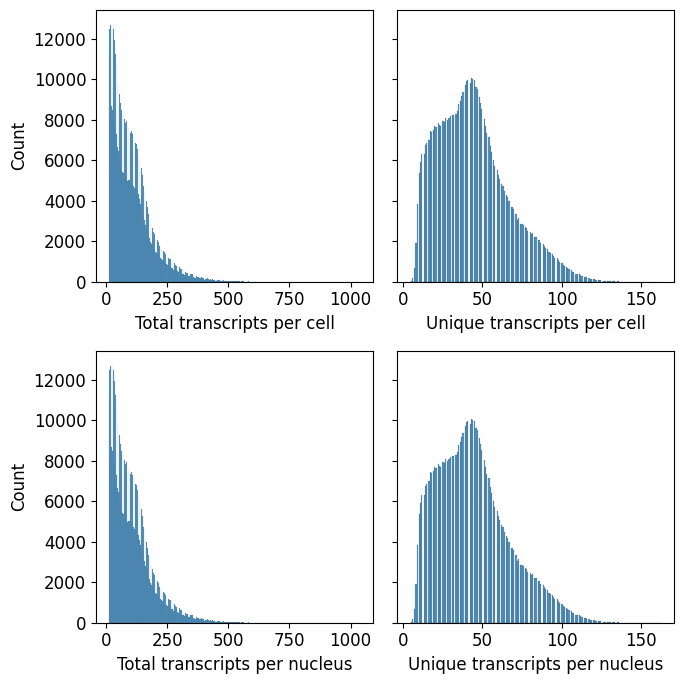

In [4]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.size']='12'

fig, ax = plt.subplots(2, 2, figsize=(7,7),sharey=True)
ax = ax.flatten()

sns.histplot(
    data.obs["total_counts"],
    kde=False,
    ax=ax[0],
)
ax[0].set_xlabel('Total transcripts per cell')

sns.histplot(
    data.obs["n_genes_by_counts"],
    kde=False,
    ax=ax[1],
)
ax[1].set_xlabel('Unique transcripts per cell')

sns.histplot(
    data.obs["total_counts"],
    kde=False,
    ax=ax[2]
)
ax[2].set_xlabel('Total transcripts per nucleus')

sns.histplot(
    data.obs["n_genes_by_counts"],
    kde=False,
    ax=ax[3],
)
ax[3].set_xlabel('Unique transcripts per nucleus')

fig.tight_layout()
plt.savefig('/home/ah2428/palmer_scratch/figs/ed5/QC.pdf',bbox_inches='tight',dpi=300)

# ED Fig. 5b Neighborhood enrichment

  0%|          | 0/1000 [00:00<?, ?/s]

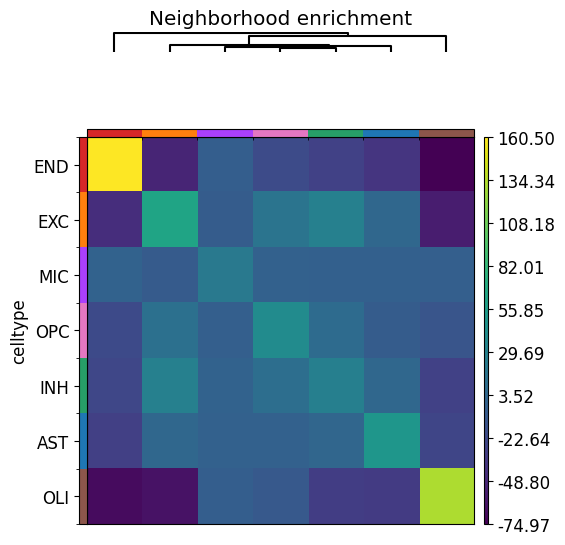

In [5]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
sq.gr.spatial_neighbors(data)
sq.gr.nhood_enrichment(data, cluster_key="celltype")
sq.pl.nhood_enrichment(data, cluster_key="celltype", method="average", figsize=(5,5))
plt.savefig('/home/ah2428/palmer_scratch/figs/ed5/neighbor.pdf',bbox_inches='tight',dpi=300)

# ED Fig. 5c CON and PTSD slide celltypes and H&E

INFO     reading /gpfs/gibbs/pi/girgenti/ah2428/xenium/data/5638_resegment/outs/cell_feature_matrix.h5             


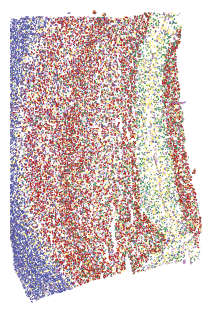

In [8]:
brnum = '5638'
#brnum = '5173'
sdata = spatialdata_io.xenium(f'/gpfs/gibbs/pi/girgenti/ah2428/xenium/data/{brnum}_resegment/outs/')
data = sc.read_h5ad('/gpfs/gibbs/pi/girgenti/ah2428/xenium/data_processed_resegment/snXenium.h5ad')
condition = data.obs[data.obs.Channel==int(brnum)].Condition.unique()[0]

sdata.tables["table"].obs['cellid'] = [x.split('-')[0] for x in sdata.tables["table"].obs['cell_id'].values]
df = data.obs[data.obs.cellid.isin(sdata.tables["table"].obs.cellid)][['cellid','celltype']]
subtypes = []
for cell in sdata.tables['table'].obs['cellid'].values:
    if cell in df.cellid.values:
        subtype = df[df.cellid==cell].celltype.values[0]
    else:
        subtype = 'NA'
    subtypes.append(subtype)
sdata.tables["table"].obs['celltype'] = subtypes
sdata.tables['table'].obs['celltype'] = sdata.tables['table'].obs['celltype'].astype('category')

sc.pp.normalize_total(sdata.tables["table"])
sc.pp.log1p(sdata.tables["table"])
sc.pp.highly_variable_genes(sdata.tables["table"])
sdata.tables["table"].var.sort_values("means")
sdata.tables["table"].obs["region"] = "cell_boundaries"
sdata.set_table_annotates_spatialelement("table", region="cell_boundaries")

cells = sdata.tables['table'].obs[sdata.tables['table'].obs.celltype.isin(['EXC','INH','OLI','OPC','END','AST','MIC'])].cell_labels.values
cells = [int(c)-1 for c in cells]
sdata_new = sdata.tables['table'][cells,:]
sdata.tables['table'] = sdata_new
cellids = sdata.tables['table'].obs.cell_id.values
cell_boundaries = sdata.shapes['cell_boundaries'] 
cell_circles = sdata.shapes['cell_circles']
nucleus_boundaries = sdata.shapes['nucleus_boundaries']
sdata.shapes['cell_boundaries'] = cell_boundaries[cell_boundaries.index.isin(cellids)]
sdata.shapes['cell_circles'] = cell_circles[cell_circles.index.isin(cellids)]
sdata.shapes['nucleus_boundaries'] = nucleus_boundaries[nucleus_boundaries.index.isin(cellids)]

sc.pp.normalize_total(sdata.tables["table"])
sc.pp.log1p(sdata.tables["table"])
sc.pp.highly_variable_genes(sdata.tables["table"])
sdata.tables["table"].var.sort_values("means")
sdata.tables["table"].obs["region"] = "cell_boundaries"
sdata.set_table_annotates_spatialelement("table", region="cell_boundaries")

sdata.tables['table'].obs.celltype = sdata.tables['table'].obs.celltype.cat.reorder_categories(['EXC','INH','OLI','OPC','END','AST','MIC'])
sdata.pl.render_shapes("cell_boundaries",
                       color='celltype',
                       groups=['EXC','INH','OLI','OPC','END','AST','MIC'],
                       palette=['#b22222', '#2E8B57', '#5254a3', '#aec7e8', '#bc80bd', '#ffed6f', '#7f7f7f'],
                       scale=5, outline=False).pl.show(figsize=(2,4))
plt.legend('',frameon=False)
plt.axis('off')
plt.title('')
plt.show()


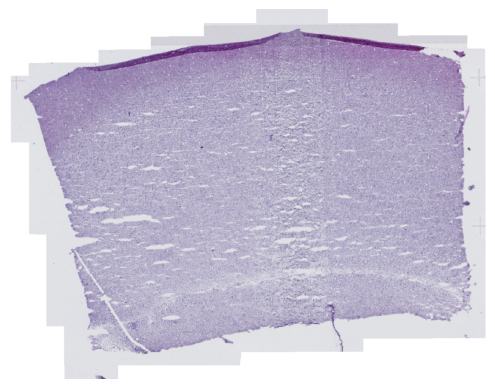

In [11]:
img = czifile.imread("/home/ah2428/girgenti/ah2428/xenium/histology/5638_dlpfc_XeniumH&E20x.czi")
plt.imshow(img)
plt.axis('off')
plt.savefig('/home/ah2428/palmer_scratch/figs/ed5/CON_h&e.pdf',bbox_inches='tight',dpi=500)

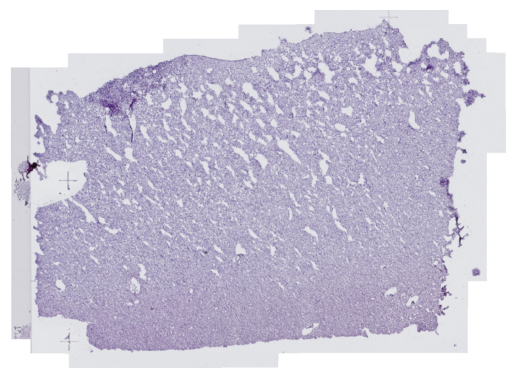

In [12]:
img = czifile.imread("/home/ah2428/girgenti/ah2428/xenium/histology/5173_dlpfc_XeniumH&E20x.czi")
plt.imshow(img)
plt.axis('off')
plt.savefig('/home/ah2428/palmer_scratch/figs/ed5/PTSD_h&e.pdf',bbox_inches='tight',dpi=500)

# ED Fig. 5d snXenium vs snRNA log2FC correlation 

In [16]:
xenium_genes = pd.read_csv('/home/ah2428/palmer_scratch/PTSD/xenium/xenium_genes.csv',header=None)[0].values

In [24]:
xenium_ups_n = []
xenium_downs_n = []
xenium_ups = []
xenium_downs = []

#mast = pd.read_csv(f'/home/ah2428/ShareZhangLab/PTSD/RNA/DEG_results_df/snXenium/PTSD_vs_CON/MAST_DEG.csv',sep='\t')
mast = pd.read_csv(f'/home/ah2428/ShareZhangLab/PTSD/RNA/DEG_results_df/scXenium/PTSD_vs_CON/MAST_DEG.csv',sep='\t')

for celltype in ['EXC','INH','OLI','OPC','END','AST','MIC']:
    mast_celltype = mast[mast.Celltype==celltype]
    mast_up = mast_celltype[mast_celltype.log2FC > np.log2(1.1)][mast_celltype.FDR < 0.01].Genename.values
    mast_down = mast_celltype[mast_celltype.log2FC < -np.log2(1.1)][mast_celltype.FDR < 0.01].Genename.values
    
    xenium_ups_n.append(len(mast_up))
    xenium_downs_n.append(len(mast_down))
    xenium_ups.append(mast_up)
    xenium_downs.append(mast_down)

In [25]:
rna_ups_n = []
rna_downs_n = []
rna_ups = []
rna_downs = []

mast = pd.read_csv(f'/home/ah2428/ShareZhangLab/PTSD/RNA/DEG_results_df/snRNA/PTSD_vs_CON/MAST_DEG.csv',sep='\t')

for celltype in ['EXC','INH','OLI','OPC','END','AST','MIC']:
    mast_celltype = mast[mast.Celltype==celltype]
    mast_up = mast_celltype[mast_celltype.log2FC > np.log2(1.2)][mast_celltype.FDR < 0.01].Genename.values
    mast_down = mast_celltype[mast_celltype.log2FC < -np.log2(1.2)][mast_celltype.FDR < 0.01].Genename.values

    inter_up = list(set(mast_up) & set(xenium_genes))
    inter_down = list(set(mast_down) & set(xenium_genes))
    rna_ups.append(inter_up)
    rna_downs.append(inter_down)
    rna_ups_n.append(len(inter_up))
    rna_downs_n.append(len(inter_down))

In [26]:
inter_up_genes = []
for i,celltype in enumerate(['EXN','IN','OLG','OPC','END','AST','MG']):
    rna_up = rna_ups[i]
    xenium_up = xenium_ups[i]
    overlap = len(list(set(rna_up) & set(xenium_up)))
    inter_up_genes.append(list(set(rna_up) & set(xenium_up)))

In [27]:
inter_down_genes = []
for i,celltype in enumerate(['EXC','INH','OLI','OPC','END','AST','MIC']):
    rna_down = rna_downs[i]
    xenium_down = xenium_downs[i]
    overlap = len(list(set(rna_down) & set(xenium_down)))
    inter_down_genes.append(list(set(rna_down) & set(xenium_down)))

In [28]:
rna_mast = pd.read_csv('/home/ah2428/ShareZhangLab/PTSD/RNA/DEG_results_df/snRNA/PTSD_vs_CON/MAST_DEG.csv',sep='\t')
#xenium_mast = pd.read_csv('/home/ah2428/ShareZhangLab/PTSD/RNA/DEG_results_df/snXenium/PTSD_vs_CON/MAST_DEG.csv',sep='\t')
xenium_mast = pd.read_csv('/home/ah2428/ShareZhangLab/PTSD/RNA/DEG_results_df/scXenium/PTSD_vs_CON/MAST_DEG.csv',sep='\t')

In [29]:
rna_fcs = []
xenium_fcs = []
for ii,celltype in enumerate(['EXC','INH','OLI','OPC','END','AST','MIC']):
    genes_up = inter_up_genes[ii]
    genes_down = inter_down_genes[ii]
    rna_celltype = rna_mast[rna_mast.Celltype==celltype]
    xenium_celltype = xenium_mast[xenium_mast.Celltype==celltype]
    if len(genes_up) >= 1:
        for g in genes_up:
            rna_fc = rna_celltype[rna_celltype.Genename==g].log2FC.values[0]
            xenium_fc = xenium_celltype[xenium_celltype.Genename==g].log2FC.values[0]
            rna_fcs.append(rna_fc)
            xenium_fcs.append(xenium_fc)
    else:
        pass
    if len(genes_down) >= 1:
        for j in genes_down:
            rna_fc = rna_celltype[rna_celltype.Genename==j].log2FC.values[0]
            xenium_fc = xenium_celltype[xenium_celltype.Genename==j].log2FC.values[0]
            rna_fcs.append(rna_fc)
            xenium_fcs.append(xenium_fc)
    else:
        pass

Text(0, 0.5, 'snRNA log2FC')

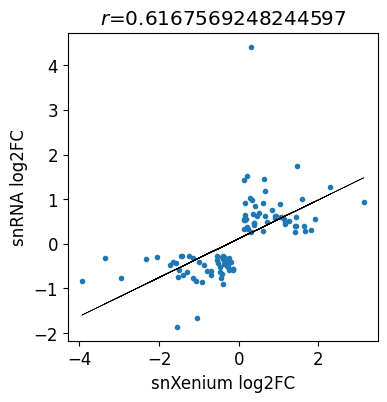

In [23]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
fig, ax = plt.subplots(figsize=(4,4))
x = xenium_fcs
y = rna_fcs
y = np.array(y)
x = np.array(x)

ax.plot(x,y,'.')
r = np.corrcoef(x,y)[0][1]
m, b = np.polyfit(x,y,1)
ax.plot(x, m*x+b, color='k',linewidth=0.5)
ax.set_title(f'$r$={r}')
ax.set_xlabel('snXenium log2FC')
ax.set_ylabel('snRNA log2FC')

# ED Fig. 5d scXenium vs snRNA log2FC correlation 

Text(0, 0.5, 'snRNA log2FC')

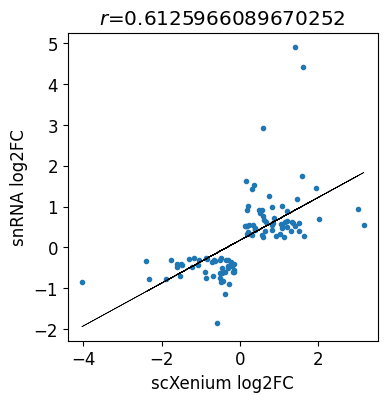

In [30]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
fig, ax = plt.subplots(figsize=(4,4))
x = xenium_fcs
y = rna_fcs
y = np.array(y)
x = np.array(x)

ax.plot(x,y,'.')
r = np.corrcoef(x,y)[0][1]
m, b = np.polyfit(x,y,1)
ax.plot(x, m*x+b, color='k',linewidth=0.5)
ax.set_title(f'$r$={r}')
ax.set_xlabel('scXenium log2FC')
ax.set_ylabel('snRNA log2FC')

# ED Fig. 5f snXenium IN PTSD vs CON MAST DEG Volcano plot

(-5.0, 5.0)

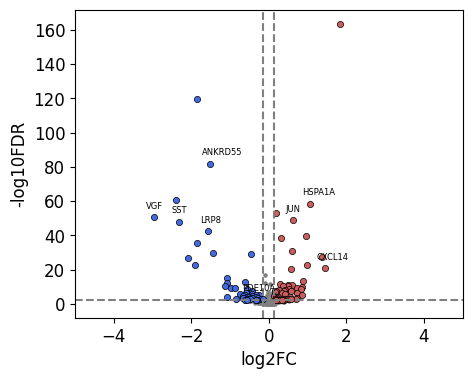

In [34]:
rna = pd.read_csv('/home/ah2428/ShareZhangLab/PTSD/RNA/DEG_results_df/snRNA/PTSD_vs_CON/MAST_DEG.csv',sep='\t')
rna = rna[rna.Celltype=='INH']
rna = rna[np.abs(rna.log2FC) > np.log2(1.2)][rna.FDR < 0.01]

rna_down = list(set(xenium_genes) & set(rna[rna.log2FC < 0].Genename.unique()))
rna_up = list(set(xenium_genes) & set(rna[rna.log2FC > 0].Genename.unique()))

deg = pd.read_csv('/home/ah2428/ShareZhangLab/PTSD/RNA/DEG_results_df/snXenium/PTSD_vs_CON/MAST_DEG.csv',sep='\t')

deg = deg[deg.Celltype=='INH']

deg.sort_values('FDR')

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
fig, ax = plt.subplots(figsize=(5,4))
plt.scatter(x=deg.log2FC,y=deg.FDR.apply(lambda x:-np.log10(x)),s=5,label="Not significant",color='gray')

# highlight down- or up- regulated genes
down = deg[(deg.log2FC < -np.log2(1.1))&(deg.FDR < 0.01)]
up = deg[(deg.log2FC > np.log2(1.1))&(deg.FDR < 0.01)]

plt.scatter(x=down['log2FC'],y=down['FDR'].apply(lambda x:-np.log10(x)),s=20,color='royalblue',edgecolor='black',linewidth=0.5)
plt.scatter(x=up['log2FC'],y=up['FDR'].apply(lambda x:-np.log10(x)),s=20,color='indianred',edgecolor='k',linewidth=0.5)
ups = []
for i in up.Genename.values:
    if i in rna_up:
        ups.append(i)
        x = up[up.Genename==i]
        plt.text(x.log2FC-0.2,-np.log10(x['FDR'])+5,i,fontsize=6)
downs = []
for i in down.Genename.values:
    if i in rna_down:
        downs.append(i)
        x = down[down.Genename==i]
        plt.text(x.log2FC-0.2,-np.log10(x['FDR'])+5,i,fontsize=6)

plt.xlabel("log2FC")
plt.ylabel("-log10FDR")
plt.axvline(-np.log2(1.1),color="grey",linestyle="--")
plt.axvline(np.log2(1.1),color="grey",linestyle="--")
plt.axhline(-np.log10(0.01),color="grey",linestyle="--")
plt.xlim([-5,5])

# ED Fig. 5g CXCL14 PTSD vs CON expression

2024-09-14 19:16:59,386 - pegasus.tools.preprocessing - INFO - Function 'log_norm' finished in 0.12s.


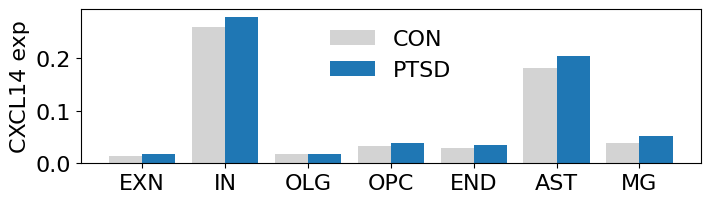

In [37]:
plot_xenium_gene_exp_barplot('CXCL14')

# ED Fig. 5h CXCL14 CON slide 

INFO     reading /gpfs/gibbs/pi/girgenti/ah2428/xenium/data/5638_resegment/outs/cell_feature_matrix.h5             


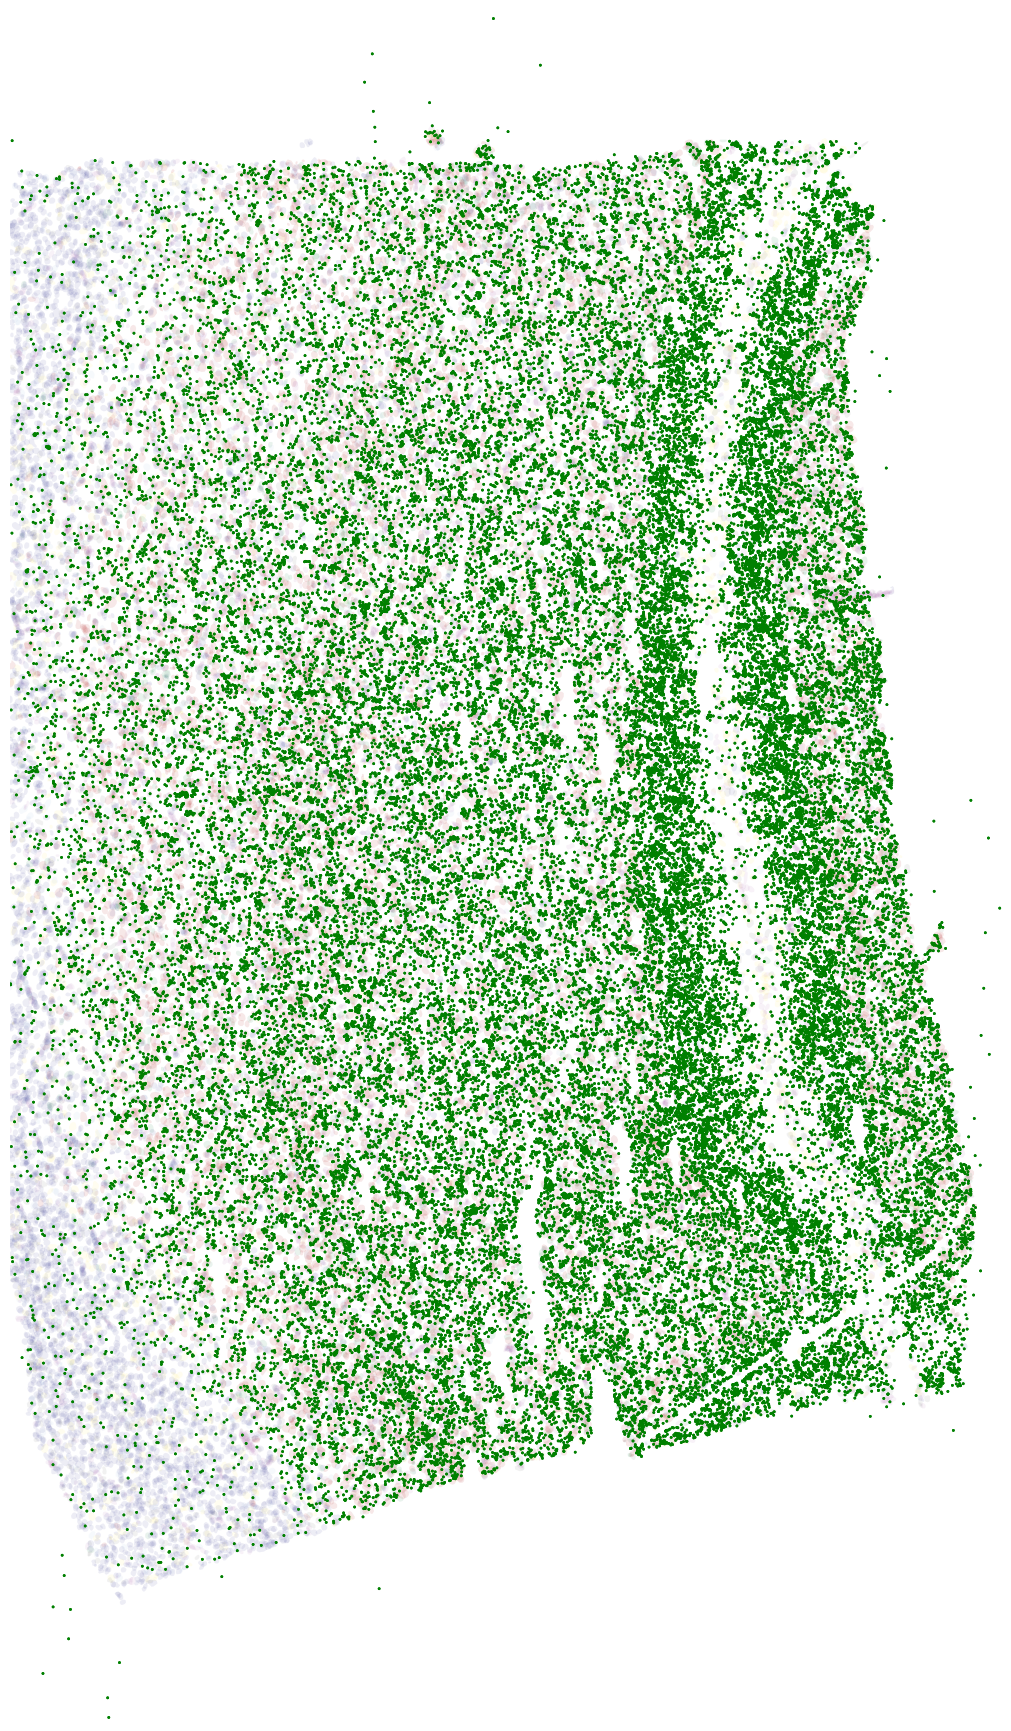

In [38]:
sdata = plot_xenium_slide('5638','CXCL14','green','/home/ah2428/palmer_scratch/figs/ed5/')

In [40]:
crop0 = lambda x: bounding_box_query(
    x,
    min_coordinate=[15000,10000],
    max_coordinate=[20000,15000],
    axes=("x", "y"),
    target_coordinate_system="global",
)
subset = crop0(sdata)

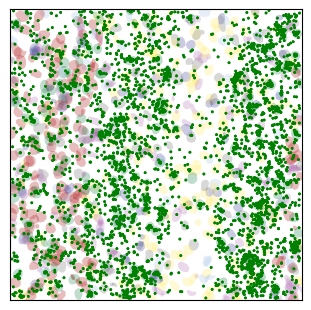

In [41]:
subset.pl.render_shapes("cell_boundaries",
                       color='celltype',
                       groups=['EXC','INH','OLI','OPC','END','AST','MIC'],
                       palette=['#b22222','#2E8B57','#5254a3','#aec7e8','#bc80bd','#ffed6f','#7f7f7f'],
                       scale=5, 
                       outline=False, 
                       fill_alpha=0.3).pl.render_points('transcripts',color='feature_name',groups=gene,palette='green',size=1).pl.show(figsize=(3,3))
plt.title('')
plt.legend('',frameon=False)
plt.title('')
plt.xticks([])
plt.yticks([])
plt.savefig('/home/ah2428/palmer_scratch/figs/ed5/CXCL14_CON_inset.pdf',bbox_inches='tight',dpi=300)
plt.show()

In [32]:
crop0 = lambda x: bounding_box_query(
    x,
    min_coordinate=[3500,27000],
    max_coordinate=[8500,32000],
    axes=("x", "y"),
    target_coordinate_system="global",
)
subset = crop0(sdata_ptsd)

# ED Fig. 5i CXCL14 PTSD slide

INFO     reading /gpfs/gibbs/pi/girgenti/ah2428/xenium/data/5173_resegment/outs/cell_feature_matrix.h5             


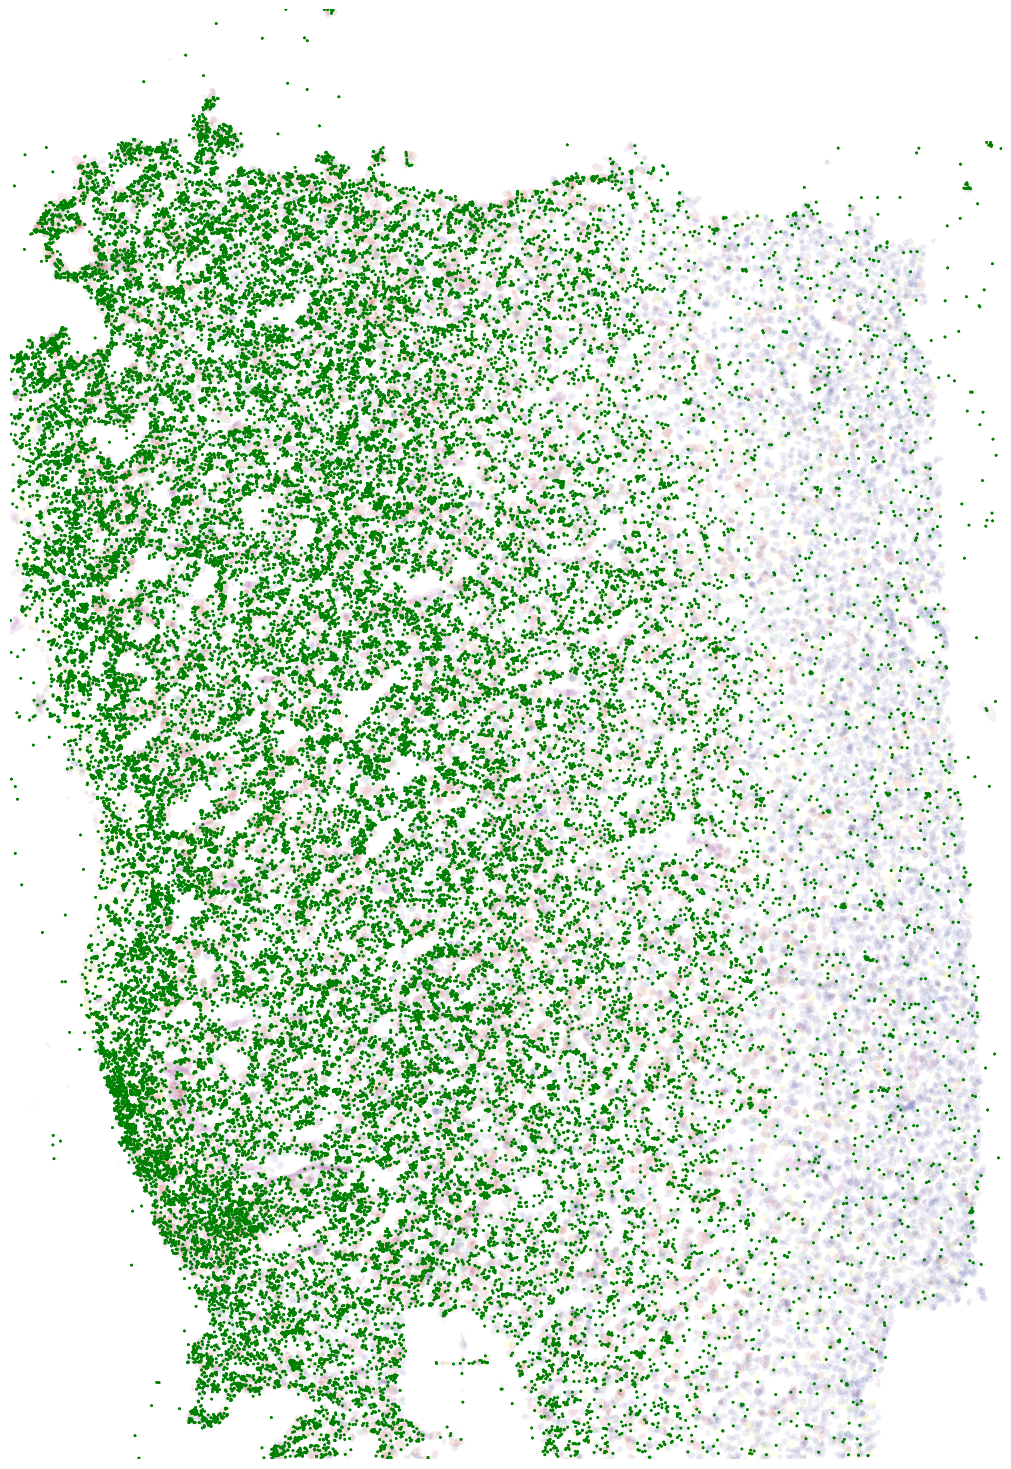

In [42]:
sdata = plot_xenium_slide('5173','CXCL14','green','/home/ah2428/palmer_scratch/figs/ed5/')

In [43]:
crop0 = lambda x: bounding_box_query(
    x,
    min_coordinate=[3500,27000],
    max_coordinate=[8500,32000],
    axes=("x", "y"),
    target_coordinate_system="global",
)
subset = crop0(sdata)

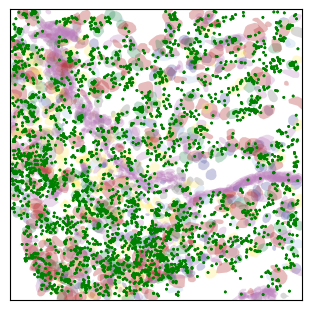

In [44]:
subset.pl.render_shapes("cell_boundaries",
                       color='celltype',
                       groups=['EXC','INH','OLI','OPC','END','AST','MIC'],
                       palette=['#b22222','#2E8B57','#5254a3','#aec7e8','#bc80bd','#ffed6f','#7f7f7f'],
                       scale=5, 
                       outline=False, 
                       fill_alpha=0.3).pl.render_points('transcripts',color='feature_name',groups=gene,palette='green',size=1).pl.show(figsize=(3,3))
plt.title('')
plt.legend('',frameon=False)
plt.title('')
plt.xticks([])
plt.yticks([])
plt.savefig('/home/ah2428/palmer_scratch/figs/ed5/CXCL14_PTSD_inset.pdf',bbox_inches='tight',dpi=300)
plt.show()